In [1]:
import os
# os.sys.path.append("C:\\Users\\markp\\repos\\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import pickle
import itertools

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [3]:
mice = ['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1']
first_sess = [5,5,5,3,5,4,4,4,4,4,4]
rare = [i<5 for i in range(len(mice))]
freq = [(1-r)>0 for r in rare]
rare_mice = mice[:5]
freq_mice = mice[5:]
print(freq_mice)

['4222153.1', '4222153.2', '4222153.3', '4222174.1', '4222154.1', '4343702.1']


In [99]:
morphbin = np.linspace(-.11,1.11,num=11)
datadict = {}
for m,mouse in enumerate(mice):
    print(mouse)
    df_mouse = df[df["MouseName"]==mouse]
    datadict[mouse]={}
    for ind in range(first_sess[m],df_mouse.shape[0]):
        print(ind)
        datadict[mouse][ind]={}
        sess = df_mouse.iloc[ind]
        with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
            data = pickle.load(f)
        VRDat,S = data['VRDat'],data['S']
        print(data.keys())
        S[np.isnan(S)]=0
        S = S/np.percentile(S,95,axis=0)
        trial_info,S_trial_mat= data['trial_info'],data['S_trial_mat']
        S_trial_mat[np.isnan(S_trial_mat)]=0
        masks, SI,pvals = pc.place_cells_calc(S, VRDat['pos']._values,trial_info,
                        data['tstart_inds'], data['teleport_inds'],
                        win_trial_perm=True,morphlist=[0,.25,.5,.75,1],bootstrap=False,nperms=1000)
        
        morphs = trial_info['morphs']+trial_info['wallJitter']
        
        datadict[mouse][ind] = {'masks':masks,'S_trial_mat':S_trial_mat,'trial_info':trial_info,'pvals':pvals}

4139265.3
5
dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
6
dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
7
dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
8
dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', 'S_trial_mat', 'occ_trial_mat', 'edges', 'centers'])
perm 0
perm 100
perm 200
perm 300
perm 400
perm 500
perm 600
perm 700
perm 800
perm 900
9
dict_keys(['VRDat', 'C', 'S', 'dFF', 'trial_info', 'tstart_inds', 'teleport_inds', '

In [100]:
with open("D:\\Morph_Results\\PCResults.pkl","wb") as f:
    pickle.dump(datadict,f)
    

In [4]:
with open("D:\\Morph_Results\\PCResults.pkl","rb") as f:
    datadict = pickle.load(f)
    

(6358, 45)
(6358, 45)
(6358, 45)
(6358, 45)
(6358, 45)
(3217, 45)
(3217, 45)
(3217, 45)
(3217, 45)
(3217, 45)
(3487, 45)
(3487, 45)
(3487, 45)
(3487, 45)
(3487, 45)
(3431, 45)
(3431, 45)
(3431, 45)
(3431, 45)
(3431, 45)
(5822, 45)
(5822, 45)
(5822, 45)
(5822, 45)
(5822, 45)


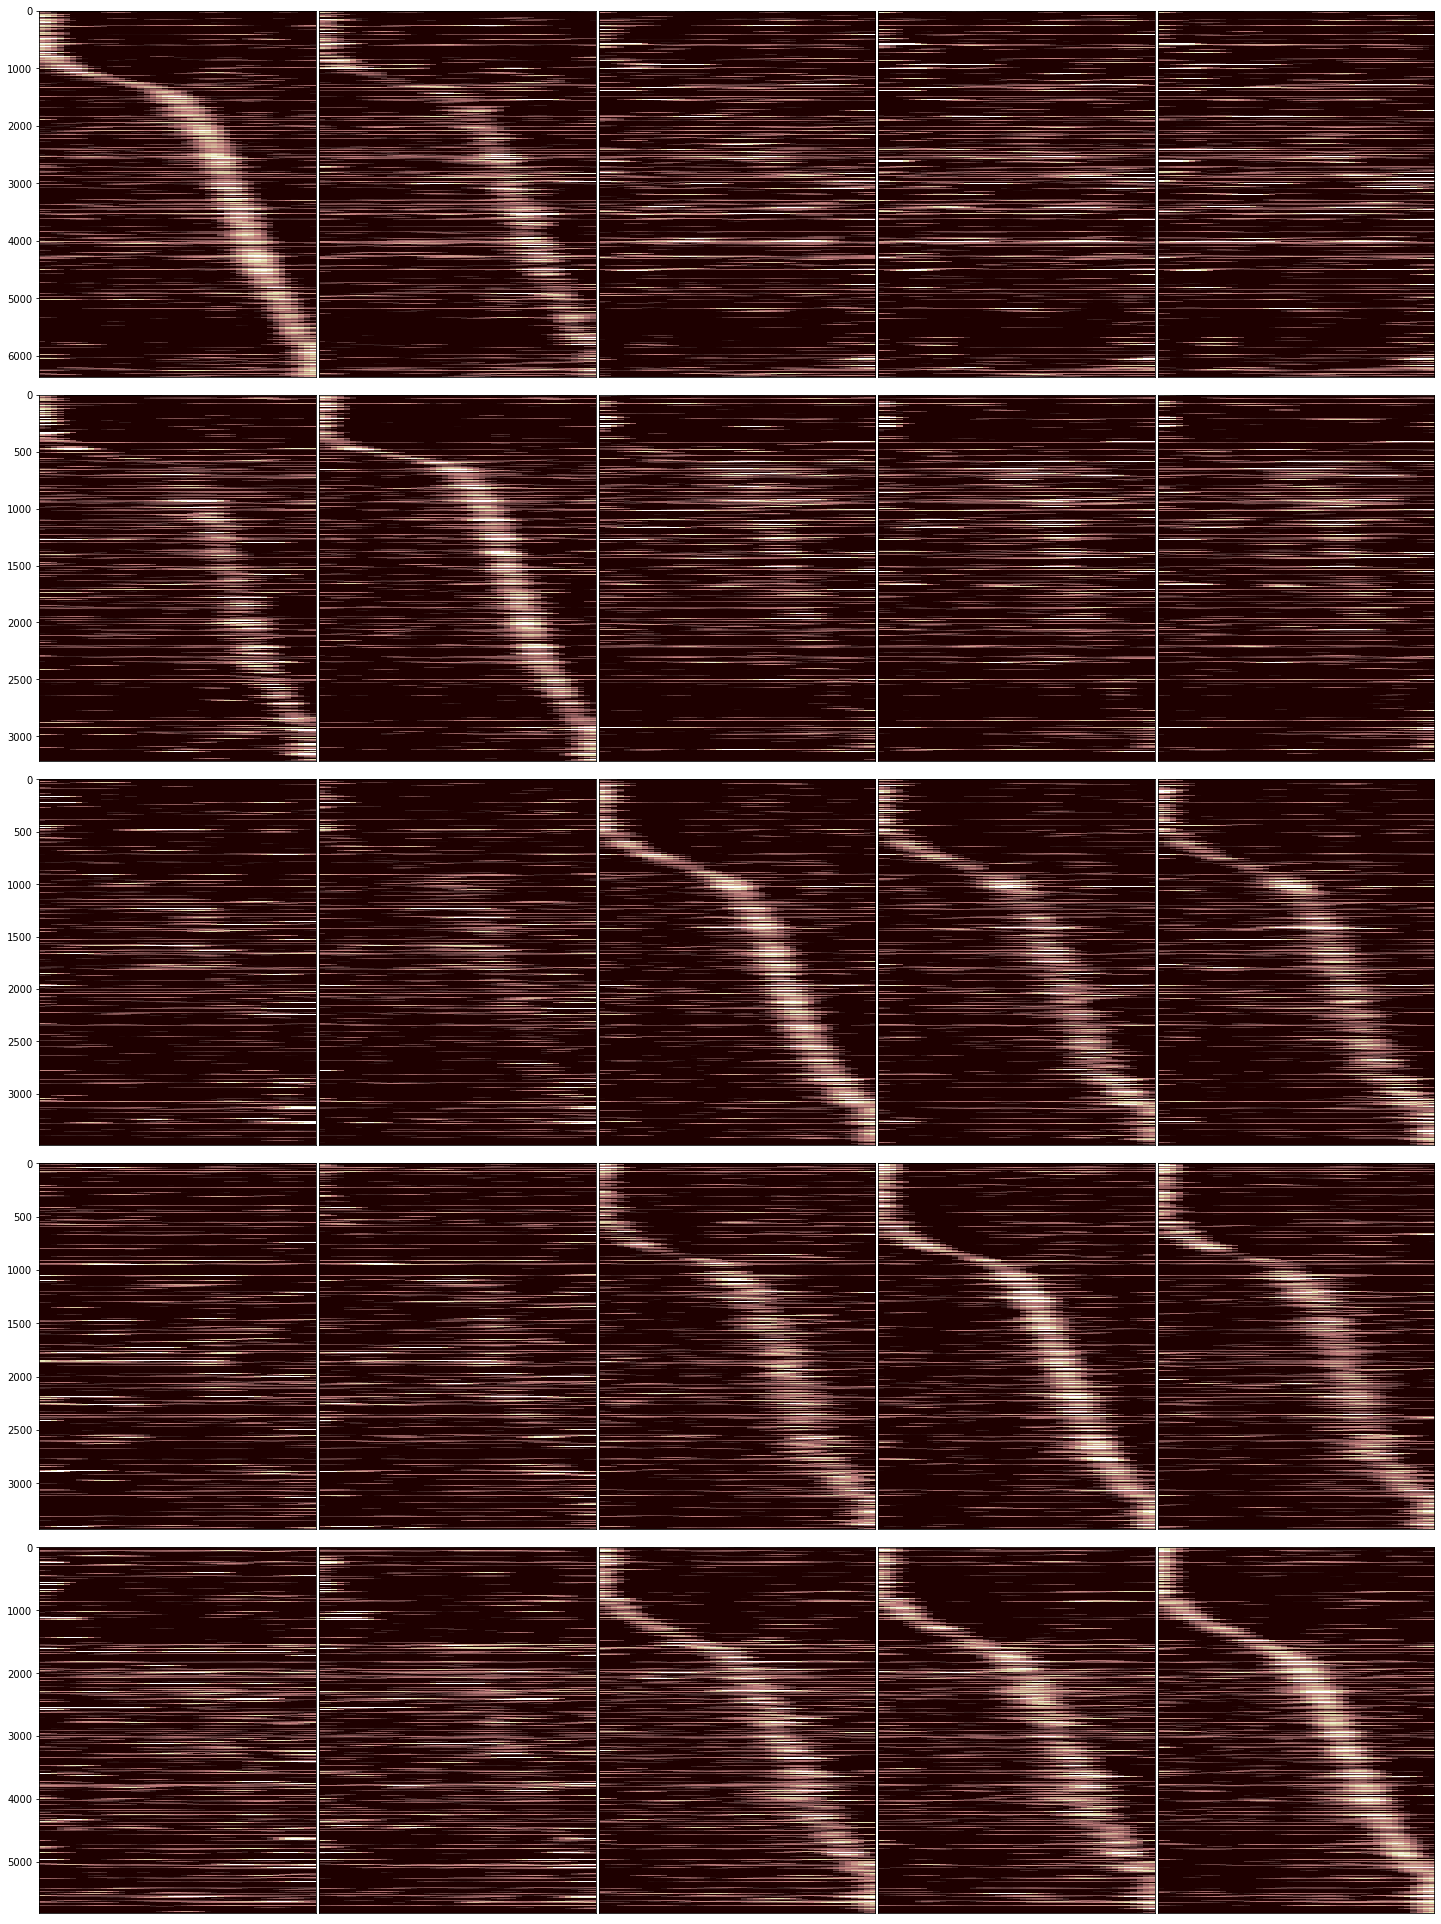

In [5]:
getSort = lambda fr : np.argsort(np.argmax(fr,axis=1))
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in rare_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\rare_all_placecells.png",format="png")

(3265, 45)
(3265, 45)
(3265, 45)
(3265, 45)
(3265, 45)
(2418, 45)
(2418, 45)
(2418, 45)
(2418, 45)
(2418, 45)
(2887, 45)
(2887, 45)
(2887, 45)
(2887, 45)
(2887, 45)
(2983, 45)
(2983, 45)
(2983, 45)
(2983, 45)
(2983, 45)
(2961, 45)
(2961, 45)
(2961, 45)
(2961, 45)
(2961, 45)


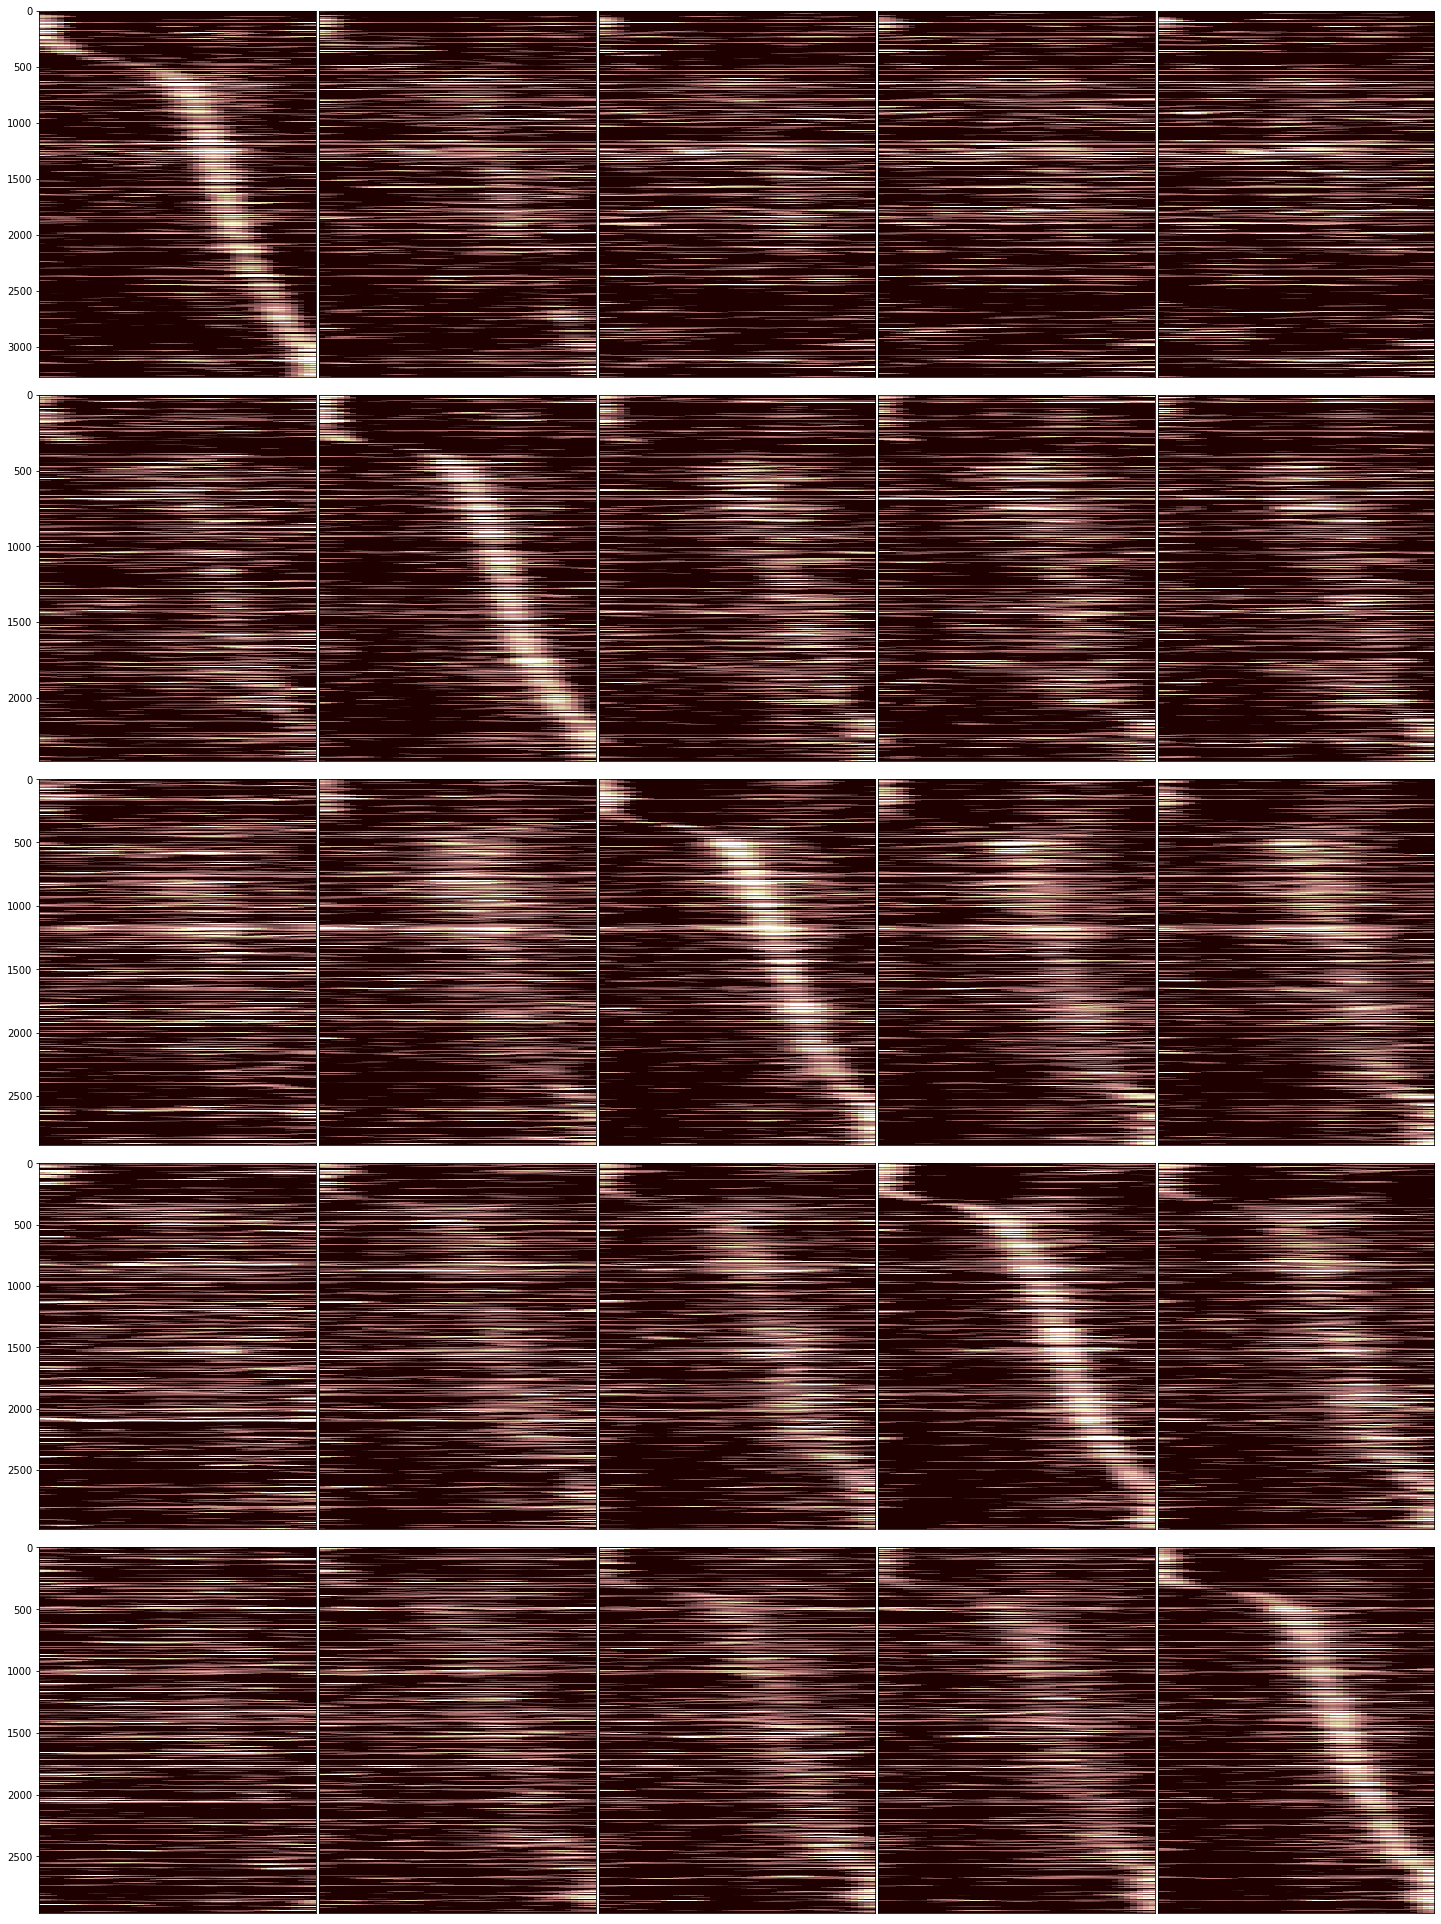

In [6]:
pc_dict = {}
for m in [0,.25,.5,.75,1]:
    pc_dict[m] = {}
    for mm in [0,.25,.5,.75,1]:
        pc_dict[m][mm]=[]
        
for mouse in freq_mice: #datadict.keys():
    for sess in datadict[mouse].keys():
        masks = datadict[mouse][sess]['masks']
        _pc_dict = pc.plot_placecells(u.trial_type_dict(datadict[mouse][sess]['S_trial_mat'],datadict[mouse][sess]['trial_info']['morphs']),masks,plot=False)
        for m in _pc_dict.keys():
            for mm in _pc_dict.keys():
                pc_dict[m][mm].append(_pc_dict[m][mm])
                
f,ax = plt.subplots(5,5,figsize=[5*5,7*5])
f.subplots_adjust(wspace=.01,hspace=.05)
for i,m in enumerate(pc_dict.keys()):
    sort = getSort(np.concatenate(pc_dict[m][m],axis=0))
    for j,mm in enumerate(pc_dict.keys()):
        pc_dict[m][mm] = np.concatenate(pc_dict[m][mm],axis=0)
        print(pc_dict[m][mm].shape)
        pc_dict[m][mm] = pc_dict[m][mm][sort,:]
        
        ax[i,j].imshow(pc_dict[m][mm],aspect='auto',cmap='pink',vmin=.2,vmax=.9)
        if j>0:
            ax[i,j].set_yticks([])
        ax[i,j].set_xticks([])
        
f.savefig("D:\\Morph_Results\\figures\\freq_all_placecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\frq_all_placecells.png",format="png")

In [7]:
mouselabel = []
rarefreqlabel = []
SM = []
sesslabel =[]
for mi, mouse in enumerate(mice):
    for si, (sess, sessdict) in enumerate(datadict[mouse].items()):
        # load data
        
        # OR mask
        for _i, (morph,mask) in enumerate(sessdict['masks'].items()):
            if _i == 0:
                ormask = mask
            else:
                ormask+=mask
        ormask = ormask>0
        
        # bin by morph value
        S_trial_mat = np.copy(sessdict['S_trial_mat'][:,:,ormask])
        S_binmat = np.zeros([5,*S_trial_mat.shape[1:]])
        for _i, m in enumerate(sessdict['masks'].keys()):
            S_binmat[_i,:,:] = S_trial_mat[sessdict['trial_info']['morphs']==m,:,:].mean(axis=0)
        S_binmat = S_binmat/np.linalg.norm(S_binmat,ord=2,axis=1,keepdims=True)
#         print(S_binmat.shape)
#         S_binmat = np.transpose(S_binmat, axes = (2,0,1))
        # similarity matrix 
        sm = np.matmul(np.transpose(S_binmat,axes=(2,0,1)),np.transpose(S_binmat,axes=(2,1,0)))
#         print(sm.shape)
        # save mouse and session index
        SM.append(sm)
        mouselabel.append(mi*np.ones((sm.shape[0],)))
        sesslabel.append(si*np.ones((sm.shape[0],)))
        if mi<5:
            rarefreqlabel.append(np.ones((sm.shape[0],)))
        else:
            rarefreqlabel.append(np.zeros((sm.shape[0],)))
    
SM = np.concatenate(SM,axis=0)
mouselabel = np.concatenate(mouselabel)
rarefreqlabel = np.concatenate(rarefreqlabel)
sesslabel = np.concatenate(sesslabel)

In [8]:
# for each permutation of mouse labels
diff_perms = []
iters =0
print(np.array(rare).sum())

for c, comb in enumerate(itertools.combinations(np.unique(mouselabel),5)):
    if c>0:
        rare_mask = np.zeros(mouselabel.shape)
        for _m_l  in comb:
#             print(_m_l)
            rare_mask += 1*(mouselabel==_m_l)
        rare_mask = rare_mask>0
#         print(SM.shape)
        diff_perms.append(SM[rare_mask,:,:].mean(axis=0)-SM[~rare_mask,:,:].mean(axis=0))
print(c)
diff_perms = np.array(diff_perms)
print(diff_perms.shape)
diff_min,diff_max = np.percentile(diff_perms,2.5,axis=0),np.percentile(diff_perms,97.5,axis=0)
print(diff_min)
print(diff_max)

5
461
(461, 5, 5)
[[ 0.         -0.0452021  -0.04105258 -0.04422717 -0.02688618]
 [-0.0452021   0.         -0.06469725 -0.06653755 -0.05059406]
 [-0.04105258 -0.06469725  0.         -0.05127065 -0.05837902]
 [-0.04422717 -0.06653755 -0.05127065  0.         -0.0549852 ]
 [-0.02688618 -0.05059406 -0.05837902 -0.0549852   0.        ]]
[[0.         0.04376319 0.04651963 0.04670125 0.02940171]
 [0.04376319 0.         0.08050256 0.08187082 0.05737745]
 [0.04651963 0.08050256 0.         0.0529181  0.05648184]
 [0.04670125 0.08187082 0.0529181  0.         0.05207413]
 [0.02940171 0.05737745 0.05648184 0.05207413 0.        ]]


[[ 0.         -0.04897786  0.05095213  0.05522196  0.03033671]
 [-0.04897786  0.          0.08055596  0.08510418  0.05736579]
 [ 0.05095213  0.08055596  0.         -0.00204279 -0.03158676]
 [ 0.05522196  0.08510418 -0.00204279  0.         -0.03604273]
 [ 0.03033671  0.05736579 -0.03158676 -0.03604273  0.        ]]


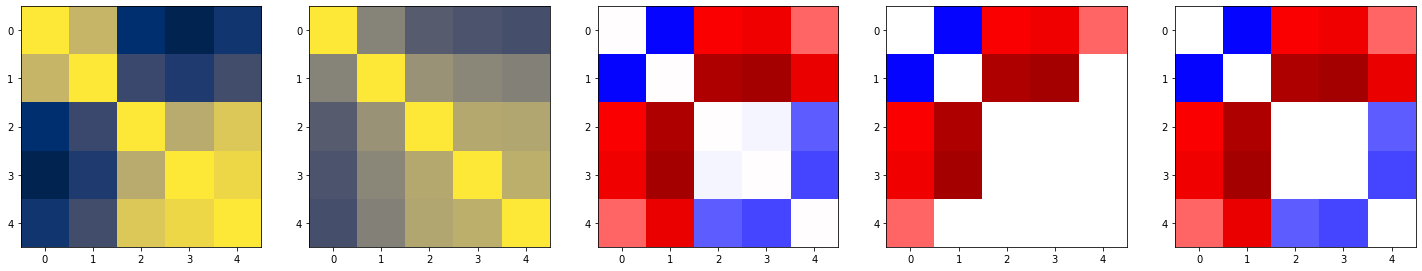

In [9]:
f,ax = plt.subplots(1,5,figsize= [25,5])
muf,mur = SM[rarefreqlabel==0,:,:].mean(axis=0),SM[rarefreqlabel==1,:,:].mean(axis=0)
diff = muf-mur
ax[0].imshow(mur,cmap='cividis',vmin=.6,vmax=.8)
ax[1].imshow(muf,cmap='cividis',vmin=.6,vmax=.8)
ax[2].imshow(diff,cmap='seismic',vmin=-.1,vmax=.1)
print(diff)
mask = ((diff>diff_max) + (diff<diff_min))>0
diff[~mask]=np.nan
ax[3].imshow(diff,cmap='seismic',vmin=-.1,vmax=.1)

t,p = sp.stats.ttest_ind(SM[rarefreqlabel==0,:],SM[rarefreqlabel==1,:],axis=0)
mask = p<.005
diff = muf-mur
diff[~mask]=np.nan
ax[4].imshow(diff,cmap='seismic',vmin=-.1,vmax=.1)

f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.pdf",format="pdf")
f.savefig("D:\\Morph_Results\\figures\\simmat_allplacecells.png",format="png")

In [67]:
print(SM.shape)

(1795, 5)


In [11]:
print(SI[0]['all'].shape)

(2746,)


In [4]:
# loop through mice

In [ ]:
# 